In [1]:
import pandas as pd
import os
import glob
import geopy.distance
import matplotlib.pyplot as plt
import requests
import math
import numpy as np
import seaborn as sns

#Lectura de los Datos

In [2]:
def read_data(folder): 
  '''
  # Pasamos el path del folder donde están los datos dinámicos
  '''
  merged_data = pd.DataFrame() 
  csv_files = glob.glob(os.path.join(folder, "*.csv"))

  for f in csv_files:  
      df = pd.read_csv(f)
      merged_data = pd.concat([merged_data,df])
  return merged_data

def segment_data(data, path_ice, path_ev):
  '''
  Pasamos los datos dinámicos (ya leídos) y los paths a los csv estáticos
  
  '''
  ice_hev = pd.read_csv(path_ice, sep = ';') 
  phev_ev = pd.read_csv(path_ev, sep = ';')
  hev_id = ice_hev.loc[ice_hev['Vehicle Type']=='HEV']
  ice_id = ice_hev.loc[ice_hev['Vehicle Type']=='ICE']
  ev_id = phev_ev.loc[phev_ev['EngineType']=='EV']
  phev_id = phev_ev.loc[phev_ev['EngineType']=='PHEV']
  ev = pd.merge(data,ev_id,on ='VehId', how = 'inner')
  phev = pd.merge(data,phev_id,on ='VehId', how = 'inner')
  hev = pd.merge(data,hev_id,on ='VehId', how = 'inner')
  ice = pd.merge(data,ice_id,on ='VehId', how = 'inner')
  return ev, phev, hev, ice

data = read_data('/content/drive/MyDrive/Monitoría EV/Data')
path_ice, path_ev ='/content/drive/MyDrive/Monitoría EV/Static Data/VED_Static_Data_ICE&HEV.csv','/content/drive/MyDrive/Monitoría EV/Static Data/VED_Static_Data_PHEV&EV.csv'
ev, phev, hev, ice = segment_data(data,path_ice,path_ev)


#Exploratory Data Analysis datos crudos

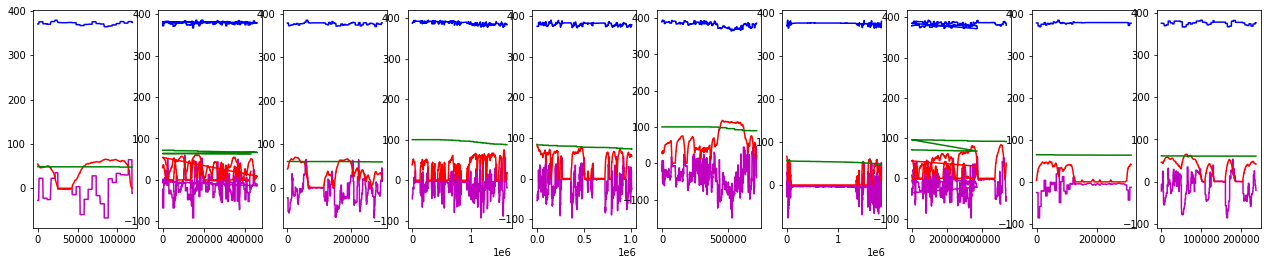

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(22,4))
trips = np.unique(ev['Trip'].values)
for i in range(10):
  trip = ev[ev['Trip'] == 1560+i]
  if len(trip) == 0:
    trip = ev[ev['Trip'] == trips[i]]
  time = trip['Timestamp(ms)'].values
  curr = trip['HV Battery Current[A]'].values
  volt = trip['HV Battery Voltage[V]'].values
  speed = trip['Vehicle Speed[km/h]'].values
  soc = trip['HV Battery SOC[%]'].values
  ax[i].plot(time,curr, 'm')
  ax[i].plot(time,volt, 'b')
  ax[i].plot(time,speed, 'r')
  ax[i].plot(time,soc, 'g')

Graficamos los trips aleatoriamente y constatamos que hay errores en las gráficas 2 y 8. Esto indica que hay 2 trips dentro de 1. Este error se arregla con el método "createidx" más abajo.

Limpiar datos carros eléctricos

In [ ]:
ev.drop(columns = ['MAF[g/sec]','Engine RPM[RPM]','Absolute Load[%]','Short Term Fuel Trim Bank 1[%]','Short Term Fuel Trim Bank 2[%]', 
                   'Long Term Fuel Trim Bank 1[%]', 'Long Term Fuel Trim Bank 2[%]','Fuel Rate[L/hr]', 'Air Conditioning Power[kW]', 'Transmission',
                   'EngineType', 'Drive Wheels', 'Engine Configuration & Displacement', 'Vehicle Class'], inplace = True)
ev.fillna(method='ffill', inplace = True)

In [ ]:
#Para ahorrar RAM
del phev
del hev
del ice

In [ ]:
def create_idx(data): 
  '''
  Agrupamos por cambio de trip y timestamps = 0
  '''
  i = 0
  j = 0
  indx = []
  idx = 0
  prevtrip = data['Trip'][0]
  for trip, time in zip(data['Trip'],data['Timestamp(ms)']):
    if prevtrip!=trip or time == 0:
      idx += 1
      pendiente = False
    indx.append(idx)
    prevtrip = trip
  return indx

indices = create_idx(ev)
ev.insert(len(ev.columns),'Indx',indices)

#Exploratory Data Analysis con índice

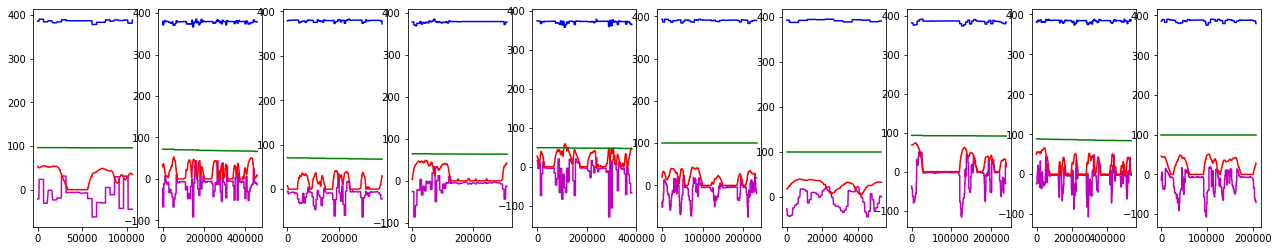

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(22,4))
for i in range(1,11):
  trip = ev[ev['Indx'] == i]
  time = trip['Timestamp(ms)'].values
  curr = trip['HV Battery Current[A]'].values
  volt = trip['HV Battery Voltage[V]'].values
  speed = trip['Vehicle Speed[km/h]'].values
  soc = trip['HV Battery SOC[%]'].values
  ax[i-1].plot(time,curr, 'm')
  ax[i-1].plot(time,volt, 'b')
  ax[i-1].plot(time,speed, 'r')
  ax[i-1].plot(time,soc, 'g')

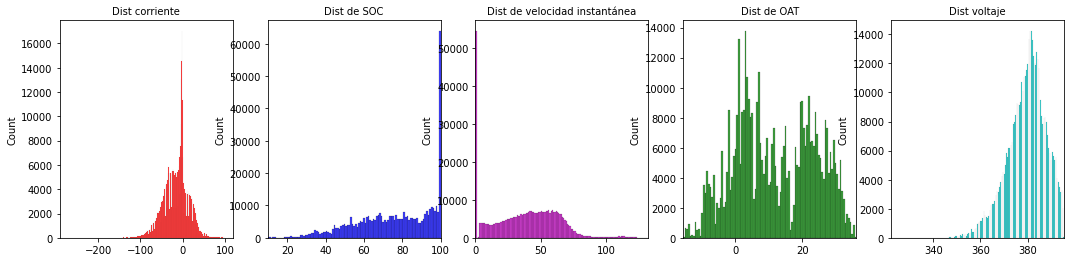

In [ ]:
def Distribution_plot(df):
    amount_val = df['HV Battery Current[A]'].values
    time_val = df['HV Battery SOC[%]'].values
    v1_val = df['Vehicle Speed[km/h]'].values
    v2_val = df['OAT[DegC]'].values
    v3_val = df['HV Battery Voltage[V]'].values

    fig, ax = plt.subplots(1, 5, figsize=(18,4))

    sns.histplot(amount_val, ax=ax[0], color='r')
    ax[0].set_title('Dist corriente', fontsize=10)
    ax[0].set_xlim([min(amount_val), max(amount_val)])

    sns.histplot(time_val, ax=ax[1], color='b')
    ax[1].set_title('Dist de SOC', fontsize=10)
    ax[1].set_xlim([min(time_val), max(time_val)])

    sns.histplot(v1_val, ax=ax[2], color='m')
    ax[2].set_title('Dist de velocidad instantánea', fontsize=10)
    ax[2].set_xlim([min(v1_val), max(v1_val)])

    sns.histplot(v2_val, ax=ax[3], color='g')
    ax[3].set_title('Dist de OAT', fontsize=10)
    ax[3].set_xlim([min(v2_val), max(v2_val)])

    sns.histplot(v3_val, ax=ax[4], color='c')
    ax[4].set_title('Dist voltaje', fontsize=10)
    ax[4].set_xlim([min(v3_val), max(v3_val)])

    plt.show()

Distribution_plot(ev)

#Agrupamos datos por trips 

Creamos variable de potencia instántanea

In [ ]:
def suma_riemann(data):
  potencia = []
  previdx = data['Trip'][0]
  prevtime = data['Timestamp(ms)'][0]
  pot = 0
  for time,curr,volt,idx in zip(data['Timestamp(ms)'][1:],data['HV Battery Current[A]'][1:],data['HV Battery Voltage[V]'][1:],data['Indx'][1:]):
    if previdx != idx:
      potencia.append(pot)
      pot = 0
    else:
      pot += -(time-prevtime)*curr*volt/3600000
    previdx = idx
    prevtime = time
  potencia.append(pot) 
  return pd.DataFrame(potencia, columns = ['Consumo'])

potencia = suma_riemann(ev)

Creamos variable de aceleración

In [ ]:
def acceleration(data):
  acel = []
  previdx = data['Trip'][0]
  prevtime = data['Timestamp(ms)'][0]
  prevspeed = data['Vehicle Speed[km/h]'][0]
  temp = []
  for time,speed,idx in zip(data['Timestamp(ms)'][1:],data['Vehicle Speed[km/h]'][1:],data['Indx'][1:]):
    if previdx != idx:
      if temp:
        acel.append(np.mean(temp))
      else:
        acel.append(0)
      temp = []
    else:
      if time != prevtime:
        temp.append((speed-prevspeed)/(time-prevtime))
    previdx = idx
    prevspeed = speed
    prevtime = time
  acel.append(np.mean(temp)) 
  return pd.DataFrame(acel, columns = ['Mean accel'])

acel = acceleration(ev)

Creamos otras variables con la función groupby de Python

In [ ]:
ev['Potencia instantanea'] = ev.apply(lambda x: -x['HV Battery Current[A]']*x['HV Battery Voltage[V]'], axis = 1)

In [ ]:
means = ev.groupby(ev['Indx']).mean().loc[:,['OAT[DegC]','Vehicle Speed[km/h]','Potencia instantanea']]
vars = ev.groupby(ev['Indx']).var().loc[:,['Vehicle Speed[km/h]']]
firsts = ev.groupby(ev['Indx']).first().loc[:,['Latitude[deg]','Longitude[deg]', 'HV Battery SOC[%]']]
lasts = ev.groupby(ev['Indx']).last().loc[:,['Latitude[deg]','Longitude[deg]', 'HV Battery SOC[%]']]
max = ev.groupby(ev['Indx']).max().loc[:,['Timestamp(ms)']]
vars.columns = ['Variance speed']
max.columns = ['Tiempo']
means.columns = ['Mean OAT', 'Mean speed', 'Consumo']
firsts.columns = ['First lat', 'First lon', 'First SOC']
lasts.columns = ['Last lat', 'Last lon', 'Last SOC']
means.drop(columns = ['Consumo'], inplace = True)
new_df = pd.concat([acel,means,potencia,vars,firsts,lasts,max],axis=1)

In [ ]:
#new_df['Consumo Total'] = new_df.apply(lambda x: x['Consumo']*x['Tiempo']/3600000, axis = 1)

In [ ]:
new_df.dropna(inplace = True)
new_df.reset_index(inplace= True)

In [ ]:
new_df

,index,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,First lat,First lon,First SOC,Last lat,Last lon,Last SOC,Tiempo
0,1,0.000208,5.000000,35.550077,121.048715,271.390017,42.277066,-83.763404,96.341469,42.278445,-83.754332,95.853661,106200.0
1,2,0.000190,4.753745,22.925093,681.465917,252.291871,42.286600,-83.732572,71.707321,42.278520,-83.751120,66.463417,460400.0
2,3,-0.000109,9.322888,19.378746,512.246354,190.701510,42.281418,-83.749432,71.097565,42.282303,-83.733756,67.560982,370300.0
3,4,0.000283,9.605634,26.365563,324.378438,304.357089,42.281197,-83.735698,64.634148,42.281192,-83.750806,63.658539,313700.0
4,5,-0.000454,14.164062,24.035848,571.837236,256.973114,42.286539,-83.732670,48.780487,42.281257,-83.750997,46.585369,382200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,500,-0.000032,6.742608,61.612861,841.000403,482.359754,42.272627,-83.799298,74.756104,42.242340,-83.767746,68.170738,375400.0
500,501,0.000269,7.000000,51.654409,1303.494868,581.721606,42.240173,-83.770212,66.829277,42.285200,-83.801421,59.268295,600500.0
501,502,-0.000009,31.437690,34.234346,174.238583,679.556641,42.285003,-83.801831,68.048782,42.291199,-83.799641,66.707321,179300.0
502,503,0.000623,30.736559,47.258816,264.418139,580.739531,42.291144,-83.799731,62.804878,42.282962,-83.788839,61.829269,191900.0


Creamos variable de distancia

In [ ]:
def dists(data):
  dists = []
  for prevlat,prevlon,lat,lon in zip(data['First lat'],data['First lon'],data['Last lat'], data['Last lon']):
    dists.append(geopy.distance.geodesic((prevlat,prevlon),(lat,lon)).m)
  return pd.DataFrame(dists, columns = ['Distance'])
distancia = dists(new_df)
new_df = pd.concat([new_df,distancia],axis=1)

Calculamos la elevación

In [ ]:
from re import T
def funcion(df1, API_endpoint, inicio, fin, first):
    data=[]
    for i in range(inicio,fin):
        if first:
          data.append([df1['First lat'][i],df1['First lon'][i]])
        else:
          data.append([df1['Last lat'][i],df1['Last lon'][i]])
    x = 0
    while x != 200:
        r = requests.post(url = API_endpoint, json= data)
        x = r.status_code
    str = r.content.decode("utf-8")
    str = str.replace('[','')
    str = str.replace(']','')
    lista = list(np.float_(str.split(',')))
    for i in range (inicio,fin):
        if first:
          df1['elevation_2'][i]=lista[i-inicio]
        else:
          df1['elevation_3'][i]=lista[i-inicio]
    return(df1)

API_ENDPOINT = "https://elevation.racemap.com/api"
new_df.insert(len(new_df.columns),'elevation_2',[np.nan]*len(new_df))
new_df.insert(len(new_df.columns),'elevation_3',[np.nan]*len(new_df))
new_df = funcion(new_df,API_ENDPOINT,0,len(new_df), True)
new_df = funcion(new_df,API_ENDPOINT,0,len(new_df), False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
new_df['Delta SOC'] = new_df.apply(lambda x: x['First SOC'] - x['Last SOC'], axis=1)

Creamos variable de pendiente

In [ ]:
def slope(data):
  slope = []
  for prevelev,elev,dist in zip(data['elevation_2'],data['elevation_3'],data['Distance']):
    try:
      slope.append(math.degrees(math.asin((elev-prevelev)/dist)))
    except:
      slope.append(90)
    prevelev = elev
  return pd.DataFrame(slope, columns = ['Slope'])
pendiente = slope(new_df)
new_df = pd.concat([new_df,pendiente],axis = 1)

Limpiar datos

In [ ]:
new_df.drop(columns=['elevation_2','elevation_3','First SOC','Last SOC', 'First lon', 'First lat', 'Last lon', 'Last lat', 'index'],inplace=True)

In [ ]:
new_df

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Delta SOC,Slope
0,0.000208,5.000000,35.550077,121.048715,271.390017,106200.0,763.821127,0.487808,-1.030679
1,0.000190,4.753745,22.925093,681.465917,252.291871,460400.0,1773.704977,5.243904,0.205055
2,-0.000109,9.322888,19.378746,512.246354,190.701510,370300.0,1296.739092,3.536583,0.637728
3,0.000283,9.605634,26.365563,324.378438,304.357089,313700.0,1246.188118,0.975609,-0.819197
4,-0.000454,14.164062,24.035848,571.837236,256.973114,382200.0,1621.468834,2.195118,0.297245
...,...,...,...,...,...,...,...,...,...
499,-0.000032,6.742608,61.612861,841.000403,482.359754,375400.0,4254.000042,6.585365,-0.241342
500,0.000269,7.000000,51.654409,1303.494868,581.721606,600500.0,5625.492071,7.560982,-0.023288
501,-0.000009,31.437690,34.234346,174.238583,679.556641,179300.0,711.587296,1.341461,0.878282
502,0.000623,30.736559,47.258816,264.418139,580.739531,191900.0,1277.864375,0.975609,-0.114110


#Exploratory Data Analysis con datos agrupados


In [ ]:
new_df.drop(columns =['Delta SOC'],inplace=True)
new_df.corr()

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Slope
Mean accel,1.000000,0.061034,-0.125912,0.072620,-0.048645,0.053159,0.016625,0.050572
Mean OAT,0.061034,1.000000,0.124220,-0.154414,0.038952,0.016457,-0.020772,-0.010829
Mean speed,-0.125912,0.124220,1.000000,0.090948,0.384242,-0.188493,0.331845,-0.036301
Consumo,0.072620,-0.154414,0.090948,1.000000,0.363894,0.785937,0.562916,0.114248
Variance speed,-0.048645,0.038952,0.384242,0.363894,1.000000,0.234929,0.462216,0.022665
Tiempo,0.053159,0.016457,-0.188493,0.785937,0.234929,1.000000,0.470140,-0.015427
Distance,0.016625,-0.020772,0.331845,0.562916,0.462216,0.470140,1.000000,0.013279
Slope,0.050572,-0.010829,-0.036301,0.114248,0.022665,-0.015427,0.013279,1.000000


In [ ]:
new_df.corr(method = 'spearman')

,Mean accel,Mean OAT,Mean speed,Consumo,Variance speed,Tiempo,Distance,Slope
Mean accel,1.000000,0.060123,-0.096486,0.142518,-0.033737,0.104085,0.054057,0.067052
Mean OAT,0.060123,1.000000,0.106778,-0.204159,0.017154,-0.012081,-0.032743,-0.033936
Mean speed,-0.096486,0.106778,1.000000,0.043692,0.289363,-0.184591,0.254794,-0.091942
Consumo,0.142518,-0.204159,0.043692,1.000000,0.454550,0.872370,0.759420,0.173240
Variance speed,-0.033737,0.017154,0.289363,0.454550,1.000000,0.390690,0.422494,-0.005547
Tiempo,0.104085,-0.012081,-0.184591,0.872370,0.390690,1.000000,0.728172,0.038571
Distance,0.054057,-0.032743,0.254794,0.759420,0.422494,0.728172,1.000000,-0.001851
Slope,0.067052,-0.033936,-0.091942,0.173240,-0.005547,0.038571,-0.001851,1.000000


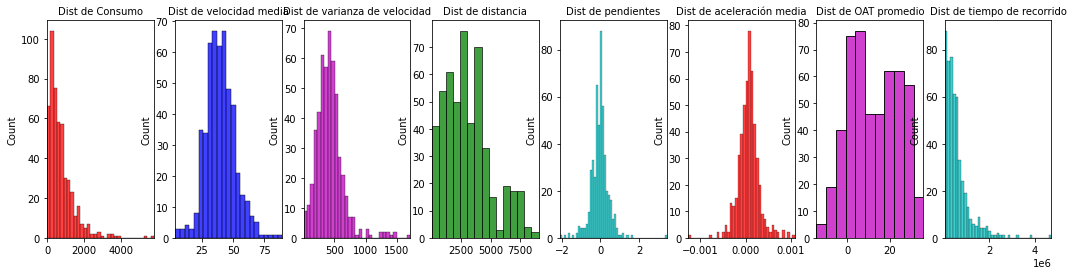

In [ ]:
def Distribution_plot(df):
    amount_val = df['Consumo'].values
    time_val = df['Mean speed'].values
    v1_val = df['Variance speed'].values
    v2_val = df['Distance'].values
    v3_val = df['Slope'].values
    v4_val = df['Mean accel'].values
    v5_val = df['Mean OAT'].values
    v6_val = df['Tiempo'].values

    fig, ax = plt.subplots(1, 8, figsize=(18,4))

    sns.histplot(amount_val, ax=ax[0], color='r')
    ax[0].set_title('Dist de Consumo', fontsize=10)
    ax[0].set_xlim([min(amount_val), max(amount_val)])

    sns.histplot(time_val, ax=ax[1], color='b')
    ax[1].set_title('Dist de velocidad media', fontsize=10)
    ax[1].set_xlim([min(time_val), max(time_val)])

    sns.histplot(v1_val, ax=ax[2], color='m')
    ax[2].set_title('Dist de varianza de velocidad', fontsize=10)
    ax[2].set_xlim([min(v1_val), max(v1_val)])

    sns.histplot(v2_val, ax=ax[3], color='g')
    ax[3].set_title('Dist de distancia', fontsize=10)
    ax[3].set_xlim([min(v2_val), max(v2_val)])

    sns.histplot(v3_val, ax=ax[4], color='c')
    ax[4].set_title('Dist de pendientes', fontsize=10)
    ax[4].set_xlim([min(v3_val), max(v3_val)])

    sns.histplot(v4_val, ax=ax[5], color='r')
    ax[5].set_title('Dist de aceleración media', fontsize=10)
    ax[5].set_xlim([min(v4_val), max(v4_val)])

    sns.histplot(v5_val, ax=ax[6], color='m')
    ax[6].set_title('Dist de OAT promedio', fontsize=10)
    ax[6].set_xlim([min(v5_val), max(v5_val)])

    sns.histplot(v6_val, ax=ax[7], color='c')
    ax[7].set_title('Dist de tiempo de recorrido', fontsize=10)
    ax[7].set_xlim([min(v6_val), max(v6_val)])

    plt.show()

Distribution_plot(new_df)

#Entrenamiento de modelos

Linear Regression Score:  0.6841532748204282 0.12376121631234815
Tree Regression Score:  0.6699432055885284 0.12266208640562269
Lasso Regression Score:  0.6781178680659258 0.12548137420172725
GBR Score:  0.8271946865797863 0.057195982546063326


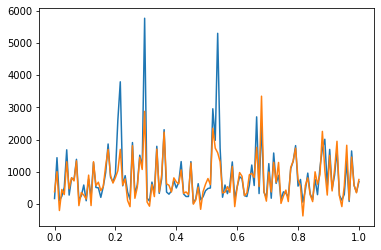

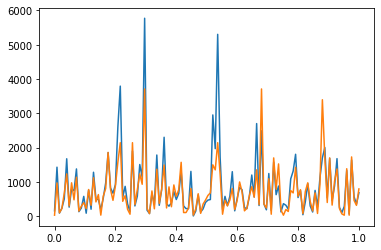

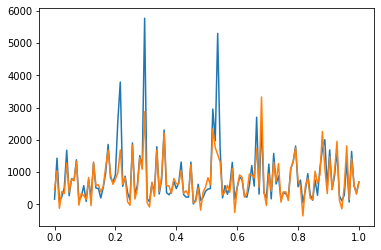

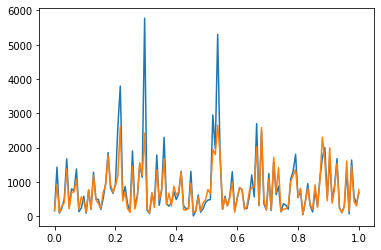

In [ ]:
from sklearn.linear_model import LinearRegression, QuantileRegressor, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

new_df = new_df.dropna()
y = new_df['Consumo']
X = new_df.drop(columns=['Consumo'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , np.mean(scores), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , np.mean(scores), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
[(variance_inflation_factor(X.values, i),X.columns[i])
                          for i in range(len(X.columns))]
#Hay un VIF alto para Mean speed

[(1.0913003876446141, 'Mean accel'),
 (2.2097700510290146, 'Mean OAT'),
 (7.4868915946648045, 'Mean speed'),
 (6.453622222862601, 'Variance speed'),
 (2.8428560006561465, 'Tiempo'),
 (5.980205864215794, 'Distance'),
 (1.0102116547388107, 'Slope')]

Linear Regression Score:  0.6967416687143163 0.11222535969526903
Tree Regression Score:  0.4948686474629259 0.2409261600113628
Lasso Regression Score:  0.6956322213072894 0.11535172595990022
GBR Score:  0.7557897728734542 0.11848621101276859


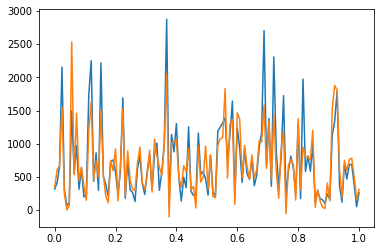

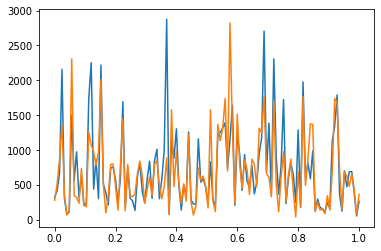

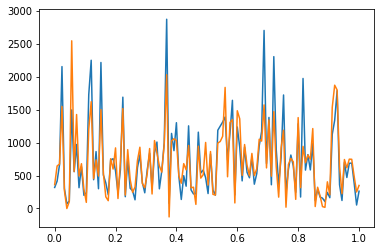

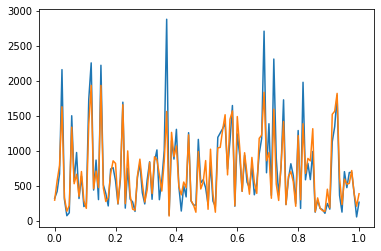

In [ ]:
from sklearn.linear_model import LinearRegression, QuantileRegressor, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

new_df = new_df.dropna()
y = new_df['Consumo']
X = new_df.drop(columns=['Consumo', 'Mean speed'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , np.mean(scores), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , np.mean(scores), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

from sklearn.ensemble import GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , np.mean(scores), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

#Modelos sin outliers

In [ ]:
from scipy.spatial.distance import mahalanobis
import scipy as sp
def cut_outliers(data):
  Sx = data.cov().values
  invcov = sp.linalg.inv(Sx)
  mean = data.mean().values
  x_minus_mu = data-mean
  left_term = np.dot(x_minus_mu,invcov)
  mahal_nueva = np.dot(left_term,x_minus_mu.T)
  dist = np.diag(mahal_nueva)
  p = np.percentile(dist,90)
  data.insert(len(data.columns), 'Mahal', dist)
  data = data[data['Mahal']<p]
  new_data = data.drop(columns = ['Mahal'], axis=1)
  return new_data
no_outliers = cut_outliers(new_df)
new_df.drop(columns = ['Mahal'], inplace = True)

Linear Regression Score:  0.7827401357882232 0.08979658329301884
Tree Regression Score:  0.7182574497727885 0.09652765891650912
Lasso Regression Score:  0.7812901623060557 0.08576935527500963
GBR Score:  0.8691298215163652 0.029466326074253094


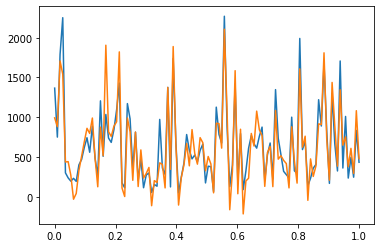

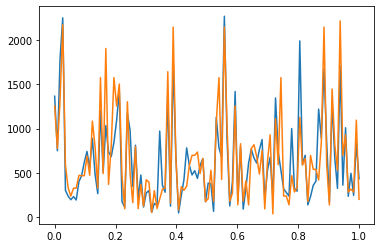

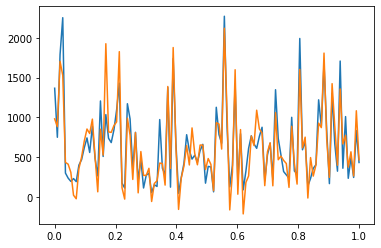

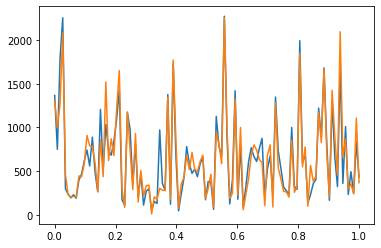

In [ ]:
y = no_outliers['Consumo']
X = no_outliers.drop(columns=['Consumo'])
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(LinearRegression(), X, y, cv=10)
print('Linear Regression Score: ' , scores.mean(), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

regressor = DecisionTreeRegressor(random_state=0)
model = regressor.fit(X_train,y_train)
scores = cross_val_score(regressor, X, y, cv=10)
print('Tree Regression Score: ' , scores.mean(), scores.std())
predicted = model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

reg = Lasso().fit(X_train, y_train)
scores = cross_val_score(Lasso(), X, y, cv=10)
print('Lasso Regression Score: ' , scores.mean(), scores.std())
predicted = reg.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)

params = {
    "n_estimators": 800,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
model = reg.fit(X_train, y_train)
scores = cross_val_score(reg, X, y, cv=10)
print('GBR Score: ' , scores.mean(), scores.std())
predicted =  model.predict(X_test)
fig, ax = plt.subplots()
x = np.linspace(0,1,len(y_test))
ax.plot(x, y_test)
ax.plot(x, predicted)